# Analyzing r/wallstreetbets
# Sean Ta
# CS4620 - Capstone Project
# Advisor: Lan Yang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from datetime import datetime,date
from sklearn.feature_extraction.text import CountVectorizer
stop = stopwords.words('english')
import emoji
import re
pd.set_option('max_colwidth', 400)

## Data Preprocessing

### Importing Data and Splitting Data

In [76]:
url = 'https://drive.google.com/file/d/1MX-7No6o9xDWoqWklV_rUWpW-796VEwL/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a message. 🚀💎🙌",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/comments/l6uhhn/exit_the_system/,47,1.611862e+09,"The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)\n\nNow SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the ric...",2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC brothers should be aware of this",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [77]:
df.shape

(53187, 8)

In [4]:
df.info() # body has a bunch of null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      53187 non-null  object 
 1   score      53187 non-null  int64  
 2   id         53187 non-null  object 
 3   url        53187 non-null  object 
 4   comms_num  53187 non-null  int64  
 5   created    53187 non-null  float64
 6   body       24738 non-null  object 
 7   timestamp  53187 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.2+ MB


In [5]:
df.isnull().sum() # body has 28449 null values, almost half. we should drop those values

title            0
score            0
id               0
url              0
comms_num        0
created          0
body         28449
timestamp        0
dtype: int64

In [6]:
# examining title only
df_title = df[['title','timestamp']]
df_title = df_title.dropna(how='any')
print('# rows for df_title:',len(df_title))

# examining body only
df_body = df[['body','timestamp']]
df_body = df_body.dropna(how='any')
print('# rows for df_body: ',len(df_body))

# rows for df_title: 53187
# rows for df_body:  24738


### Title Data Cleaning

In [7]:
df_title.head(25)

,title,timestamp
0,"It's not about the money, it's about sending a message. 🚀💎🙌",2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts,2021-01-28 21:32:10
2,Exit the system,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC brothers should be aware of this",2021-01-28 21:26:56
5,WE BREAKING THROUGH,2021-01-28 21:26:30
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,2021-01-28 21:26:27
7,THIS IS THE MOMENT,2021-01-28 21:19:31
8,Currently Holding AMC and NOK - Is it retarded that I think I should move it all to GME today?,2021-01-28 21:19:16
9,I have nothing to say but BRUH I am speechless TO THE MOON 🚀🚀🚀💎💎👋👋,2021-01-28 21:18:37


In [8]:
def remove_emoji(string): # function to remove emojis
    return emoji.replace_emoji(string, '')

df_title['title'] = df_title['title'].apply(remove_emoji) # removing emojis
df_title['title'] = df_title['title'].str.replace("[\d_]", ' ',regex = True) # removes digits and underscore (_)
df_title['title'] = df_title['title'].str.lower() # lowering all characters
df_title['title'] = df_title['title'].str.replace('[^\w\s]', '',regex = True) # remove special characters
df_title['title'] = df_title['title'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) # remove single characters
df_title['timestamp'] = pd.to_datetime(df_title['timestamp']).dt.date # keep date and remove time from timestamp

In [9]:
df_title.head(25)

,title,timestamp
0,its not about the money its about sending message,2021-01-28
1,math professor scott steiner says the numbers spell disaster for gamestop shorts,2021-01-28
2,exit the system,2021-01-28
3,new sec filing for gme can someone less retarded than me please interpret,2021-01-28
4,not to distract from gme just thought our amc brothers should be aware of this,2021-01-28
5,we breaking through,2021-01-28
6,short stock doesnt have an expiration date,2021-01-28
7,this is the moment,2021-01-28
8,currently holding amc and nok is it retarded that think should move it all to gme today,2021-01-28
9,i have nothing to say but bruh am speechless to the moon,2021-01-28


### Body Data Cleaning

In [10]:
df_body.head(25)

,body,timestamp
2,"The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)\n\nNow SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the ric...",2021-01-28 21:30:35
6,"Hedgefund whales are spreading disinfo saying Friday is make-or-break for $GME. Call options expiring ITM on Friday will drive the price up if levels are maintained, but may not trigger the short squeeze.\n\nIt may be Friday, but it could be next week the we see the real squeeze.\n\nDON'T PANIC IF THE SQUEEZE DOESN'T HAPPEN FRIDAY.\n\nIt's not guaranteed to. The only thing that is guaranteed m...",2021-01-28 21:26:27
7,"Life isn't fair. My mother always told me that when I would complain about arbitrary treatment. I would play by the rules and someone else would ignore them. When they would win I would appeal to the first authority for an explanation. ""Are you going to let them get away with this""? ""Life isn't fair"". No, it is not. The game is the game. Always.\n\nIn this moment, the fascade cracks further. W...",2021-01-28 21:19:31
10,"I believe right now is one of those rare opportunities that we all can help and do good. Some of these companies like GME, AMC are good companies that's been hit hard by this pandemic. Hedgefunds and Wallstreet just want to short these companies to zero and make millions. \n\n I really think right now we have enough support and enough of us to change that direction in history. Wallstreet says...",2021-01-28 21:18:25
12,"You guys are champs. GME... who would have thought a bunch of crazy retards could reach the front page of the New York Times.\n\nAnd when you're done with GME, it's time to punish the big banks who have been suppressing the price of silver since the Bear Stearns / JPM merge. It's all in fucking Bloomberg:\n\n[https://www.bloomberg.com/news/articles/2019-09-16/precious-metals-traders-charged-wi...",2021-01-28 21:17:10
13,"Firstly, all of you diamond hands and smooth-brains are hereby promoted to Brigadier General today. Paper hands should be ashamed to succumbing to the pressure from dementor hedge funds.\n\nI would also like to preface this post with the fact that this is not a war on billionaires, the wealthy yada yada, but it may well be described as a resistance against injustice, inequiality, poverty, rigg...",2021-01-28 21:15:58
19,Your daily trading discussion thread. Please keep the shitposting to a minimum. \n\n^Navigate ^WSB |^We ^recommend ^best ^daily ^DD\n:--|:-- \n**DD** | [All](https://reddit.com/r/wallstreetbets/search?sort=new&restrict_sr=on&q=flair%3ADD) / [**Best Daily**](https://www.reddit.com/r/wallstreetbets/search?sort=top&q=flair%3ADD&restrict_sr=on&t=day) / [Best Weekly]...,2021-01-28 21:00:15
21,"This is our time. If anyone will listen to you, please explain to them why GME is one of the very best investments they can make right now. I have already gotten 5 people close to me to research what is happening and they decided to dump everything into GME. NOT AMC, NOT NOK, NOT BB, but GME. After last night's AH manipulation I am not selling until at least 5k to 10k a share. We need to encou...",2021-01-28 20:54:08
23,"I still remember when I first joined and most people here were going all in on binary options trades on things like trial results being positive or negative from a pharmaceutical company. Back when penny stocks weren't against the rules, the days of delisted tickers like OMVS and the others. I know a lot of you (about 2 million in the past couple of days) are new here, but I just wanted to say...",2021-01-28 20:49:39
30,https://youtu.be/BtjhgcAMYU0,2021-01-28 20:37:36


In [11]:
df_body['body'] = df_body['body'].apply(remove_emoji) # removing emojis
df_body['body'] = df_body['body'].str.replace('[\d_]', ' ',regex = True) # removes digits and underscore (_)
df_body['body'] = df_body['body'].str.lower() # lowering all characters
df_body['body'] = df_body['body'].str.replace('[^\w\s]', '',regex = True) # remove special characters
df_body['body'] = df_body['body'].str.replace(r'http\S+', '', regex = True) # remove URLS
df_body['body'] = df_body['body'].str.replace('\n', ' ',regex = True) # remove '\n'
df_body['body'] = df_body['body'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x)) # remove single characters
df_body['timestamp'] = pd.to_datetime(df_body['timestamp']).dt.date # keep date and remove time from timestamp

In [12]:
df_body.head(25)

,body,timestamp
2,the ceo of nasdaq pushed to halt trading to give investorschance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we getwell shucks you should have known investing is risky have you tried cu...,2021-01-28
6,hedgefund whales are spreading disinfo saying friday is makeorbreak for gme call options expiring itm on friday will drive the price up if levels are maintained but may not trigger the short squeeze it may be friday but it could be next week the we see the real squeeze dont panic if the squeeze doesnt happen friday its not guaranteed to the only thing that is guaranteed mathematically is th...,2021-01-28
7,life isnt fair my mother always told me that whenwould complain about arbitrary treatmentwould play by the rules and someone else would ignore them when they would winwould appeal to the first authority for an explanation are you going to let them get away with this life isnt fair no it is not the game is the game always in this moment the fascade cracks further when the first breach was made...,2021-01-28
10,believe right now is one of those rare opportunities that we all can help and do good some of these companies like gme amc are good companies thats been hit hard by this pandemic hedgefunds and wallstreet just want to short these companies to zero and make millionsreally think right now we have enough support and enough of us to change that direction in history wallstreet says well weak compa...,2021-01-28
12,you guys are champs gme who would have thoughtbunch of crazy retards could reach the front page of the new york times and when youre done with gme its time to punish the big banks who have been suppressing the price of silver since the bear stearns jpm merge its all in fucking bloomberg preciousmetalstraderschargedwithriggingfuturescontracts preciousmetalstraderschargedwithri...,2021-01-28
13,firstly all of you diamond hands and smoothbrains are hereby promoted to brigadier general today paper hands should be ashamed to succumbing to the pressure from dementor hedge fundswould also like to preface this post with the fact that this is notwar on billionaires the wealthy yada yada but it may well be described asresistance against injustice inequiality poverty rigged rules uneven playi...,2021-01-28
19,your daily trading discussion thread please keep the shitposting tominimum navigate wsb we recommend best daily dd dd all sronqflair add best daily addrestrict srontday best weekly addrestrict srontweek discussion all sronqflair adiscussion best daily adiscussionrestrict srontday best weekly adiscussionrestrict srontweek yolo all sronqflair ayolo bes...,2021-01-28
21,this is our time if anyone will listen to you please explain to them why gme is one of the very best investments they can make right nowhave already gotten people close to me to research what is happening and they decided to dump everything into gme not amc not nok not bb but gme after last nights ah manipulationam not selling until at leasttoa share we need to encourage people to have the c...,2021-01-28
23,i still remember whenfirst joined and most people here were going all in on binary options trades on things like trial results being positive or negative frompharmaceutical company back when penny stocks werent against the rules the days of delisted tickers like omvs and the othersknowlot of you about million in the past couple of days are new here butjust wanted to say this has been one hel...,2021-01-28
30,,2021-01-28


## Generating WordClouds

### Title

In [13]:
# removing stopwords
df_title['title_without_stopwords'] = df_title['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_title[['title','title_without_stopwords']].head(25)

,title,title_without_stopwords
0,its not about the money its about sending message,money sending message
1,math professor scott steiner says the numbers spell disaster for gamestop shorts,math professor scott steiner says numbers spell disaster gamestop shorts
2,exit the system,exit system
3,new sec filing for gme can someone less retarded than me please interpret,new sec filing gme someone less retarded please interpret
4,not to distract from gme just thought our amc brothers should be aware of this,distract gme thought amc brothers aware
5,we breaking through,breaking
6,short stock doesnt have an expiration date,short stock doesnt expiration date
7,this is the moment,moment
8,currently holding amc and nok is it retarded that think should move it all to gme today,currently holding amc nok retarded think move gme today
9,i have nothing to say but bruh am speechless to the moon,nothing say bruh speechless moon


(-0.5, 1599.5, 799.5, -0.5)

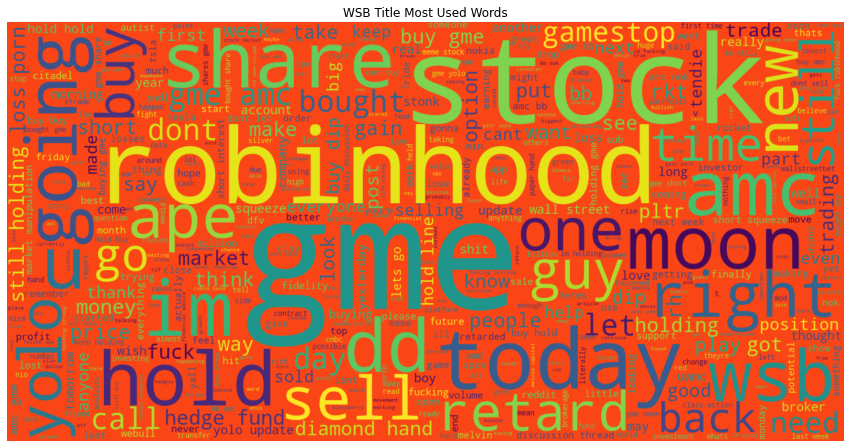

In [14]:
title_word_string=" ".join(df_title['title_without_stopwords']) # joining all text in column into one string

plt.figure(figsize=(15,15))
title_wc = WordCloud(background_color="#fa4616", max_words=500, max_font_size= 300,  width=1600, height=800)
title_wc.generate(title_word_string)

plt.imshow(title_wc.recolor(colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.title('WSB Title Most Used Words')
plt.axis('off')

### Body

In [15]:
# removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_body['body_without_stopwords'] = df_body['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_body[['body','body_without_stopwords']].head(25)

,body,body_without_stopwords
2,the ceo of nasdaq pushed to halt trading to give investorschance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we getwell shucks you should have known investing is risky have you tried cu...,ceo nasdaq pushed halt trading give investorschance recalibrate positions sec investigating brokers disallowing buying calls institutions flat admitting change rules bail rich happens us getwell shucks known investing risky tried cutting avocados coffee maybe uber side may collectively driven enough sentiment wall street make big players go long gme us money move stock much alone didnt hurt wa...
6,hedgefund whales are spreading disinfo saying friday is makeorbreak for gme call options expiring itm on friday will drive the price up if levels are maintained but may not trigger the short squeeze it may be friday but it could be next week the we see the real squeeze dont panic if the squeeze doesnt happen friday its not guaranteed to the only thing that is guaranteed mathematically is th...,hedgefund whales spreading disinfo saying friday makeorbreak gme call options expiring itm friday drive price levels maintained may trigger short squeeze may friday could next week see real squeeze dont panic squeeze doesnt happen friday guaranteed thing guaranteed mathematically shorts cover point future trying get enough people hooked false expectation friday ifwhen doesnt happen enough sell...
7,life isnt fair my mother always told me that whenwould complain about arbitrary treatmentwould play by the rules and someone else would ignore them when they would winwould appeal to the first authority for an explanation are you going to let them get away with this life isnt fair no it is not the game is the game always in this moment the fascade cracks further when the first breach was made...,life isnt fair mother always told whenwould complain arbitrary treatmentwould play rules someone else would ignore would winwould appeal first authority explanation going let get away life isnt fair game game always moment fascade cracks first breach madedo know perhaps socrates todaysee thousands millions laughing luxuries falling disgusting diseased mouths cackled unmistakable stench derisio...
10,believe right now is one of those rare opportunities that we all can help and do good some of these companies like gme amc are good companies thats been hit hard by this pandemic hedgefunds and wallstreet just want to short these companies to zero and make millionsreally think right now we have enough support and enough of us to change that direction in history wallstreet says well weak compa...,believe right one rare opportunities help good companies like gme amc good companies thats hit hard pandemic hedgefunds wallstreet want short companies zero make millionsreally think right enough support enough us change direction history wallstreet says well weak companies need go yrs road thoughwant able watchmovie inmovie theater family buy hold believe gives companiessecond chance asgroup ...
12,you guys are champs gme who would have thoughtbunch of crazy retards could reach the front page of the new york times and when youre done with gme its time to punish the big banks who have been suppressing the price of silver since the bear stearns jpm merge its all in fucking bloomberg preciousmetalstraderschargedwithriggingfuturescontracts preciousmetalstraderschargedwithri...,guys champs gme would thoughtbunch crazy retards could reach front page new york times youre done gme time punish big banks suppressing price silver since bear stearns jpm merge fucking bloomberg preciousmetalstraderschargedwithriggingfuturescontracts preciousmetalstraderschargedwithriggingfuturescontracts theres excellent explanation scheme modt modt think gme squeezed hard look happened silv...
13,firstly all of you d

(-0.5, 1599.5, 799.5, -0.5)

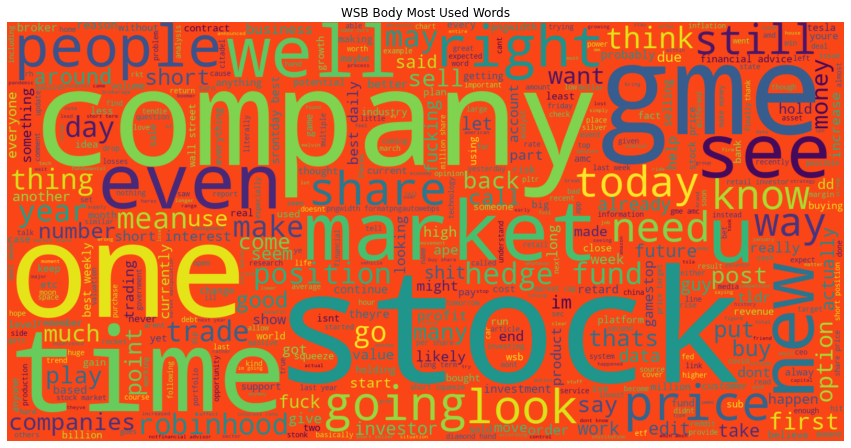

In [16]:
body_word_string=" ".join(df_body['body_without_stopwords']) # joining all text in column into one string

plt.figure(figsize=(15,15))
body_wc = WordCloud(background_color="#fa4616", max_words=500, max_font_size= 300,  width=1600, height=800)
body_wc.generate(body_word_string)

plt.imshow(body_wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.title('WSB Body Most Used Words')
plt.axis('off')

## Most Frequent N-Grams

### Unigrams - Title

In [17]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_title['title_without_stopwords'])
frequencies = sum(sparse_matrix).toarray()[0]
top_unigrams_title = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:20]

In [18]:
top_unigrams_title

In [19]:
ax = sns.barplot(data = top_unigrams_title, y=top_unigrams_title.index, x = top_unigrams_title.frequency, palette = "rocket_r")
plt.title("Most Frequent Unigrams in WSB Title", fontsize = 16)
plt.ylabel('Title Unigrams', fontsize= 14)
plt.xlabel('Frequency', fontsize= 14)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.figure.set_size_inches(12,9)

### Bigrams - Title

In [20]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_title['title_without_stopwords'])
frequencies = sum(sparse_matrix).toarray()[0]
top_bigrams_title = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:20]

In [21]:
top_bigrams_title

In [22]:
ax = sns.barplot(data = top_bigrams_title, y=top_bigrams_title.index, x = top_bigrams_title.frequency, palette = "rocket_r")
plt.title("Most Frequent Bigrams in WSB Title", fontsize = 16)
plt.ylabel('Title Bigrams', fontsize= 14)
plt.xlabel('Frequency', fontsize= 14)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.figure.set_size_inches(12,9)

### Unigrams - Body

In [23]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_body['body_without_stopwords'])
frequencies = sum(sparse_matrix).toarray()[0]
top_unigrams_body = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:20]

In [24]:
top_unigrams_body

In [25]:
ax = sns.barplot(data = top_unigrams_body, y=top_unigrams_body.index, x = top_unigrams_body.frequency, palette = "rocket_r")
plt.title("Most Frequent Unigrams in WSB Body", fontsize = 16)
plt.ylabel('Body Unigrams', fontsize= 14)
plt.xlabel('Frequency', fontsize= 14)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.figure.set_size_inches(12,9)

### Bigrams - Body

In [26]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_body['body_without_stopwords'])
frequencies = sum(sparse_matrix).toarray()[0]
top_bigrams_body = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:20]

In [27]:
top_bigrams_body

In [28]:
ax = sns.barplot(data = top_bigrams_body, y=top_bigrams_body.index, x = top_bigrams_body.frequency, palette = "rocket_r")
plt.title("Most Frequent Bigrams in WSB Body", fontsize = 16)
plt.ylabel('Body Bigrams', fontsize= 14)
plt.xlabel('Frequency', fontsize= 14)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.figure.set_size_inches(12,9)

# Sentiment Analysis

## Title Sentiment

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [30]:
df_title['neg'] = df_title['title_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
df_title['neu'] = df_title['title_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_title['pos'] = df_title['title_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_title['compound'] = df_title['title_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [31]:
df_title[['title_without_stopwords', 'neg', 'neu','pos','compound']].head(10)

,title_without_stopwords,neg,neu,pos,compound
0,money sending message,0.000,1.000,0.000,0.0000
1,math professor scott steiner says numbers spell disaster gamestop shorts,0.313,0.687,0.000,-0.6249
2,exit system,0.000,1.000,0.000,0.0000
3,new sec filing gme someone less retarded please interpret,0.274,0.563,0.163,-0.3368
4,distract gme thought amc brothers aware,0.306,0.694,0.000,-0.2960
5,breaking,0.000,1.000,0.000,0.0000
6,short stock doesnt expiration date,0.000,1.000,0.000,0.0000
7,moment,0.000,1.000,0.000,0.0000
8,currently holding amc nok retarded think move gme today,0.316,0.684,0.000,-0.5719
9,nothing say bruh speechless moon,0.000,1.000,0.000,0.0000


In [32]:
sentiment_type = [] # make an empty list to populate sentiment types

for i in df_title['compound']: # for every score in compound column
    if i > 0: # if compound > 0, sentiment type is positive
        sentiment_type.append('Positive')
    elif i < 0: # if compound < 0, sentiment type is negative
        sentiment_type.append('Negative')
    elif i == 0: # if compound == 0, sentiment type is neutral
        sentiment_type.append('Neutral')

In [33]:
df_title['sentiment_type']=pd.Series(np.array(sentiment_type)) # add list as new column to dataframe
df_title[['title_without_stopwords', 'neg', 'neu','pos','compound','sentiment_type']].head(10)

,title_without_stopwords,neg,neu,pos,compound,sentiment_type
0,money sending message,0.000,1.000,0.000,0.0000,Neutral
1,math professor scott steiner says numbers spell disaster gamestop shorts,0.313,0.687,0.000,-0.6249,Negative
2,exit system,0.000,1.000,0.000,0.0000,Neutral
3,new sec filing gme someone less retarded please interpret,0.274,0.563,0.163,-0.3368,Negative
4,distract gme thought amc brothers aware,0.306,0.694,0.000,-0.2960,Negative
5,breaking,0.000,1.000,0.000,0.0000,Neutral
6,short stock doesnt expiration date,0.000,1.000,0.000,0.0000,Neutral
7,moment,0.000,1.000,0.000,0.0000,Neutral
8,currently holding amc nok retarded think move gme today,0.316,0.684,0.000,-0.5719,Negative
9,nothing say bruh speechless moon,0.000,1.000,0.000,0.0000,Neutral


In [34]:
df_title['sentiment_type'].value_counts()

Neutral     24587
Positive    17210
Negative    11390
Name: sentiment_type, dtype: int64

## Body Sentiment

In [35]:
df_body['neg'] = df_body['body_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
df_body['neu'] = df_body['body_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_body['pos'] = df_body['body_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_body['compound'] = df_body['body_without_stopwords'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [36]:
sentiment_type_body = [] # make an empty list to populate sentiment types

for i in df_body['compound']: # for every score in compound column
    if i > 0: # if compound > 0, sentiment type is positive
        sentiment_type_body.append('Positive')
    elif i < 0: # if compound < 0, sentiment type is negative
        sentiment_type_body.append('Negative')
    elif i == 0: # if compound == 0, sentiment type is neutral
        sentiment_type_body.append('Neutral')

In [37]:
df_body['sentiment_type'] = np.array(sentiment_type_body)
df_body.head()

,body,timestamp,body_without_stopwords,neg,neu,pos,compound,sentiment_type
2,the ceo of nasdaq pushed to halt trading to give investorschance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we getwell shucks you should have known investing is risky have you tried cu...,2021-01-28,ceo nasdaq pushed halt trading give investorschance recalibrate positions sec investigating brokers disallowing buying calls institutions flat admitting change rules bail rich happens us getwell shucks known investing risky tried cutting avocados coffee maybe uber side may collectively driven enough sentiment wall street make big players go long gme us money move stock much alone didnt hurt wa...,0.063,0.823,0.113,0.7950,Positive
6,hedgefund whales are spreading disinfo saying friday is makeorbreak for gme call options expiring itm on friday will drive the price up if levels are maintained but may not trigger the short squeeze it may be friday but it could be next week the we see the real squeeze dont panic if the squeeze doesnt happen friday its not guaranteed to the only thing that is guaranteed mathematically is th...,2021-01-28,hedgefund whales spreading disinfo saying friday makeorbreak gme call options expiring itm friday drive price levels maintained may trigger short squeeze may friday could next week see real squeeze dont panic squeeze doesnt happen friday guaranteed thing guaranteed mathematically shorts cover point future trying get enough people hooked false expectation friday ifwhen doesnt happen enough sell...,0.033,0.925,0.042,0.1511,Positive
7,life isnt fair my mother always told me that whenwould complain about arbitrary treatmentwould play by the rules and someone else would ignore them when they would winwould appeal to the first authority for an explanation are you going to let them get away with this life isnt fair no it is not the game is the game always in this moment the fascade cracks further when the first breach was made...,2021-01-28,life isnt fair mother always told whenwould complain arbitrary treatmentwould play rules someone else would ignore would winwould appeal first authority explanation going let get away life isnt fair game game always moment fascade cracks first breach madedo know perhaps socrates todaysee thousands millions laughing luxuries falling disgusting diseased mouths cackled unmistakable stench derisio...,0.251,0.666,0.083,-0.9862,Negative
10,believe right now is one of those rare opportunities that we all can help and do good some of these companies like gme amc are good companies thats been hit hard by this pandemic hedgefunds and wallstreet just want to short these companies to zero and make millionsreally think right now we have enough support and enough of us to change that direction in history wallstreet says well weak compa...,2021-01-28,believe right one rare opportunities help good companies like gme amc good companies thats hit hard pandemic hedgefunds wallstreet want short companies zero make millionsreally think right enough support enough us change direction history wallstreet says well weak companies need go yrs road thoughwant able watchmovie inmovie theater family buy hold believe gives companiessecond chance asgroup ...,0.150,0.585,0.265,0.8126,Positive
12,you guys are champs gme who would have thoughtbunch of crazy retards could reach the front page of the new york times and when youre done with gme its time to punish the big banks who have been suppressing the price of silver since the bear stearns jpm merge its all in fucking bloomberg preciousmetalstraderschargedwithriggingfuturescontracts preciousmetalstraderschargedwithri...,2021-01-28,guys champs gme would thoughtbunch crazy retards could reach front page new york times youre done gme time punish big banks suppressing price silver since bear stearns jpm merge fucking

# Top Stock Mentions

In [71]:
stocks = pd.read_csv('https://raw.githubusercontent.com/sean-ta/CS4620-WSB/main/companies.csv')
stocks = stocks[['ticker','short name']]
stocks.head()

,ticker,short name
0,A,Agilent
1,AA,Alcoa
2,AABA,Altaba
3,AAC,AAC
4,AADR,AdvisorShares Dorsey Wright


In [39]:
stock_tickers_list = list(stocks['ticker'].str.lower())
stock_name_list = list(stocks['short name'].str.lower())
stock_tickers_list.extend(stock_name_list)

In [40]:
remove_words = ['ive','fix','new','well','usd','sub','su','love','life','fizz','one','tell', 'kids', 'r', 'k', 'news',
                'fund','baby','mom','post','link','ing','beat','next','via','know','play','tho','man','bond','mu', 'aware',
                'turn', 'ever', 'gain', 'land', 'flow', 'big', 'news', 'hi','data','good','fun','team','eat','stay','win',
                'see', 'nice', 'cash','else','hope','low', 'td','edit','two','per','run','ago','cost','ceo','true','target',
                'plan','tech']
new_stock_tickers_list = [word for word in stock_tickers_list if word not in remove_words]

In [41]:
def extract_company(x):
    org_list = []
    for comp in new_stock_tickers_list: # for every company in stock list
        if comp in x.split(): # if the company is in any of the rows, then we append it to a list and return it
            org_list.append(comp)
    
    return org_list

In [42]:
df_title['Company'] = df_title['title_without_stopwords'].apply(extract_company)
df_title[['title_without_stopwords','Company']].head()

,title_without_stopwords,Company
0,money sending message,[]
1,math professor scott steiner says numbers spell disaster gamestop shorts,[gamestop]
2,exit system,[]
3,new sec filing gme someone less retarded please interpret,[gme]
4,distract gme thought amc brothers aware,"[amc, gme]"


In [43]:
df_body['Company'] = df_body['body_without_stopwords'].apply(extract_company)
df_body[['body_without_stopwords','Company']].head()

,body_without_stopwords,Company
2,ceo nasdaq pushed halt trading give investorschance recalibrate positions sec investigating brokers disallowing buying calls institutions flat admitting change rules bail rich happens us getwell shucks known investing risky tried cutting avocados coffee maybe uber side may collectively driven enough sentiment wall street make big players go long gme us money move stock much alone didnt hurt wa...,"[flat, gme, pin, nasdaq]"
6,hedgefund whales spreading disinfo saying friday makeorbreak gme call options expiring itm friday drive price levels maintained may trigger short squeeze may friday could next week see real squeeze dont panic squeeze doesnt happen friday guaranteed thing guaranteed mathematically shorts cover point future trying get enough people hooked false expectation friday ifwhen doesnt happen enough sell...,"[gme, itm]"
7,life isnt fair mother always told whenwould complain arbitrary treatmentwould play rules someone else would ignore would winwould appeal first authority explanation going let get away life isnt fair game game always moment fascade cracks first breach madedo know perhaps socrates todaysee thousands millions laughing luxuries falling disgusting diseased mouths cackled unmistakable stench derisio...,"[air, echo, sun, universal]"
10,believe right one rare opportunities help good companies like gme amc good companies thats hit hard pandemic hedgefunds wallstreet want short companies zero make millionsreally think right enough support enough us change direction history wallstreet says well weak companies need go yrs road thoughwant able watchmovie inmovie theater family buy hold believe gives companiessecond chance asgroup ...,"[amc, gme, rare, road]"
12,guys champs gme would thoughtbunch crazy retards could reach front page new york times youre done gme time punish big banks suppressing price silver since bear stearns jpm merge fucking bloomberg preciousmetalstraderschargedwithriggingfuturescontracts preciousmetalstraderschargedwithriggingfuturescontracts theres excellent explanation scheme modt modt think gme squeezed hard look happened silv...,"[ag, gme, jpm, slv]"


In [44]:
replacement = {'gamestop': 'gme', 'tesla': 'tsla', 'blackberry' : 'bb'}
df_title['Company'] = df_title['Company'].apply(lambda x: [replacement[a] if a in replacement else a for a in x])
df_body['Company'] = df_body['Company'].apply(lambda x: [replacement[a] if a in replacement else a for a in x])

In [45]:
top_stocks_body = pd.Series([x for item in df_body['Company'] for x in item]).value_counts()
top_stocks_body = top_stocks_body[:5]
top_stocks_body

gme     8124
amc     2493
rh      1746
bb      1221
tsla     903
dtype: int64

In [46]:
top_stocks_title = pd.Series([x for item in df_title['Company'] for x in item]).value_counts()
top_stocks_title = top_stocks_title[:5]
top_stocks_title

gme    9274
amc    3352
rh     1324
bb     1308
nok    1017
dtype: int64

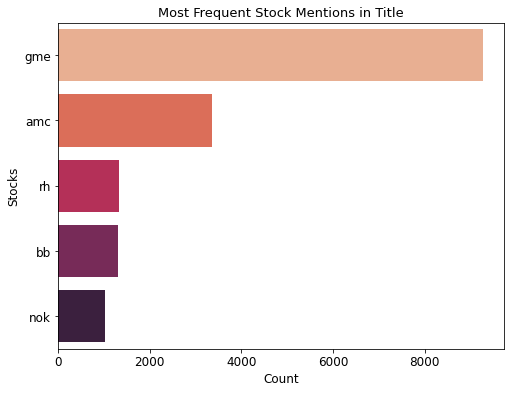

In [47]:
ax = sns.barplot(y=top_stocks_title.index, x = top_stocks_title.values, palette = "rocket_r")
plt.title("Most Frequent Stock Mentions in Title", fontsize = 13)
plt.ylabel('Stocks', fontsize= 12)
plt.xlabel('Count', fontsize= 12)
plt.tick_params(axis='both', which='major', labelsize=12)
ax.figure.set_size_inches(8,6)

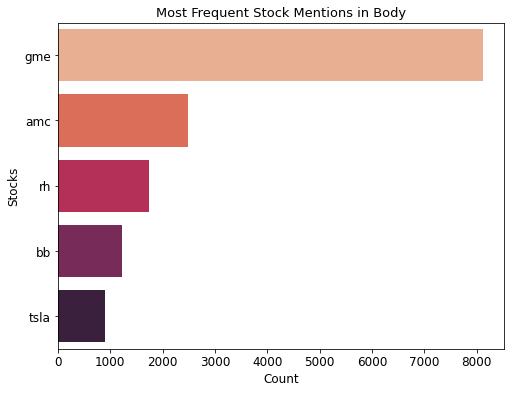

In [48]:
ax = sns.barplot(y=top_stocks_body.index, x = top_stocks_body.values, palette = "rocket_r")
plt.title("Most Frequent Stock Mentions in Body", fontsize = 13)
plt.ylabel('Stocks', fontsize= 12)
plt.xlabel('Count', fontsize= 12)
plt.tick_params(axis='both', which='major', labelsize=12)
ax.figure.set_size_inches(8,6)

# Stock Mentions VS Stock Price

In [75]:
# importing stock closing price data
gme_data = pd.read_csv("https://raw.githubusercontent.com/sean-ta/CS4620-WSB/main/GME.csv", index_col='Date',parse_dates=True)
gme_data = gme_data['Close']

amc_data = pd.read_csv("https://raw.githubusercontent.com/sean-ta/CS4620-WSB/main/AMC.csv", index_col='Date',parse_dates=True)
amc_data = amc_data['Close']

bb_data = pd.read_csv("https://raw.githubusercontent.com/sean-ta/CS4620-WSB/main/BB.csv", index_col='Date',parse_dates=True)
bb_data = bb_data['Close']

nok_data = pd.read_csv("https://raw.githubusercontent.com/sean-ta/CS4620-WSB/main/NOK.csv", index_col='Date',parse_dates=True)
nok_data = nok_data['Close']

tsla_data = pd.read_csv("https://raw.githubusercontent.com/sean-ta/CS4620-WSB/main/TSLA.csv", index_col='Date',parse_dates=True)
tsla_data = tsla_data['Close']

In [50]:
daily_body = df_body[['timestamp','Company']]
daily_title = df_title[['timestamp','Company']]

In [51]:
Date = daily_body.timestamp
daily_body_df = pd.get_dummies(daily_body.Company.apply(pd.Series).stack()).sum(level=0)
daily_body_df.insert(0, 'Date', Date)

Date = daily_title.timestamp
daily_title_df = pd.get_dummies(daily_title.Company.apply(pd.Series).stack()).sum(level=0)
daily_title_df.insert(0, 'Date', Date)

In [52]:
daily_body_df = daily_body_df.groupby(pd.Grouper(key='Date', axis=0)).sum()
daily_body_df = daily_body_df[['gme','amc','rh','bb','nok','tsla']]
daily_body_df.index = pd.to_datetime(daily_body_df.index)

daily_title_df = daily_title_df.groupby(pd.Grouper(key='Date', axis=0)).sum()
daily_title_df = daily_title_df[['gme','amc','rh','bb','nok','tsla']]
daily_title_df.index = pd.to_datetime(daily_title_df.index)

<AxesSubplot:title={'center':'Daily Stock Mentions from WSB Body'}, xlabel='Date', ylabel='Stock Mentions'>

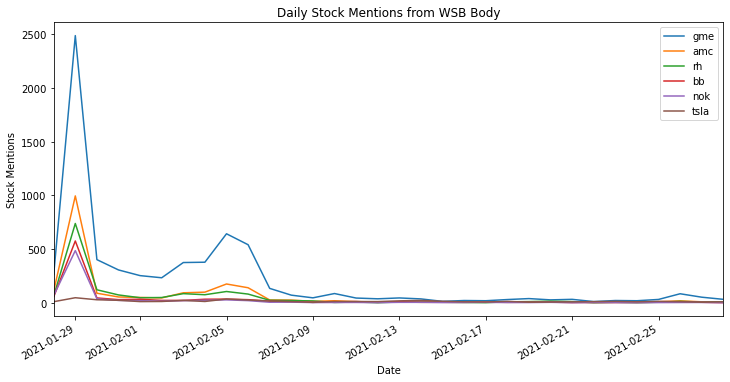

In [53]:
daily_body_df.plot(figsize=(12,6),xlim=['2021-01-28','2021-02-28'], title='Daily Stock Mentions from WSB Body', ylabel = 'Stock Mentions')

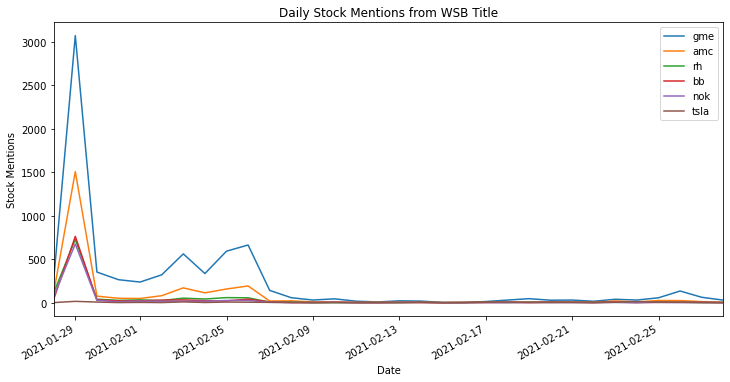

In [54]:
daily_title_df.plot(figsize=(12,6),xlim=['2021-01-28','2021-02-28'], title='Daily Stock Mentions from WSB Title', ylabel = 'Stock Mentions');

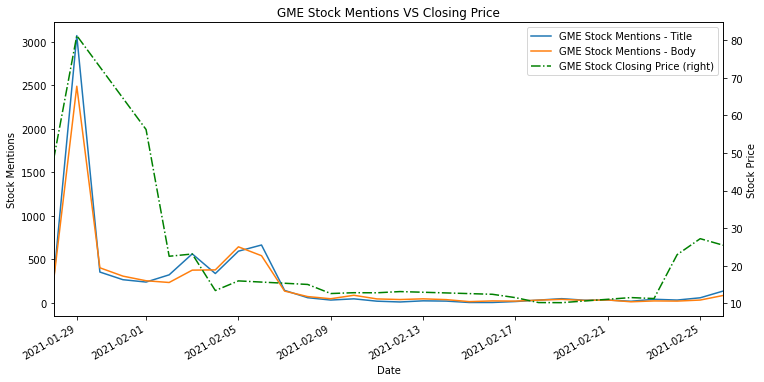

In [55]:
daily_title_df['gme'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'GME Stock Mentions - Title', legend=True, title= 'GME Stock Mentions VS Closing Price', ylabel = 'Stock Mentions')
daily_body_df['gme'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'GME Stock Mentions - Body', legend=True);
gme_data.plot(secondary_y=True, label="GME Stock Closing Price", legend=True, linestyle='dashdot', color='g')
plt.ylabel('Stock Price')
plt.style.use('ggplot')
plt.show();

In [56]:
print('GME Correlation (Title):',daily_title_df['gme'].corr(gme_data))
print('GME Correlation (Body):',daily_body_df['gme'].corr(gme_data))

GME Correlation (Title): 0.7742106816997057
GME Correlation (Body): 0.7685184616307535


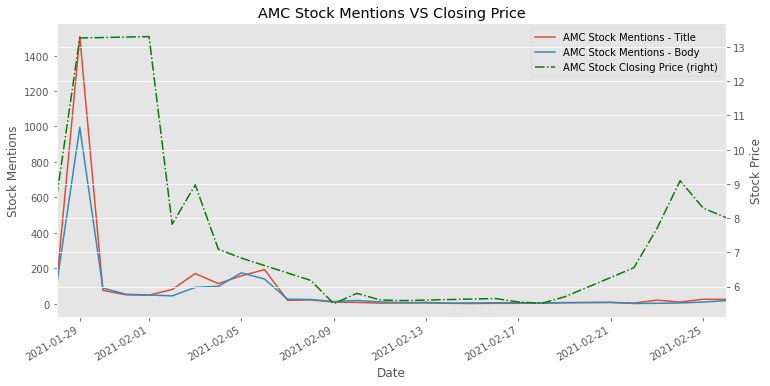

In [57]:
daily_title_df['amc'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'AMC Stock Mentions - Title', legend=True, title= 'AMC Stock Mentions VS Closing Price', ylabel = 'Stock Mentions')
daily_body_df['amc'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'AMC Stock Mentions - Body', legend=True);
amc_data.plot(secondary_y=True, label="AMC Stock Closing Price", legend=True, linestyle='dashdot', color='g')
plt.ylabel('Stock Price')
plt.show();

In [58]:
print('AMC Correlation (Title):',daily_title_df['amc'].corr(amc_data))
print('AMC Correlation (Body):',daily_body_df['amc'].corr(amc_data))

AMC Correlation (Title): 0.6213693604633791
AMC Correlation (Body): 0.6154459605766501


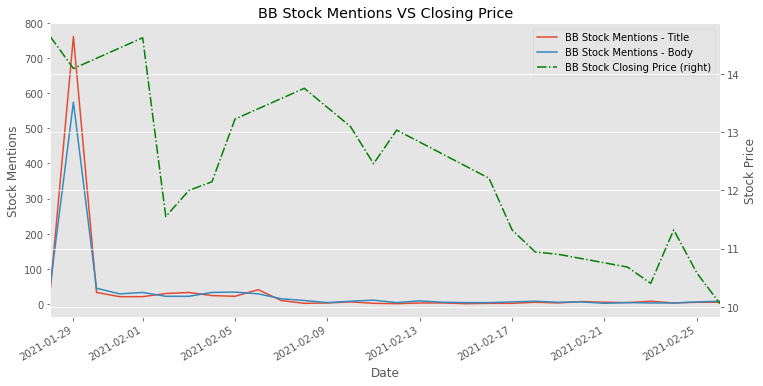

In [59]:
daily_title_df['bb'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'BB Stock Mentions - Title', legend=True, title= 'BB Stock Mentions VS Closing Price', ylabel = 'Stock Mentions')
daily_body_df['bb'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'BB Stock Mentions - Body', legend=True);
bb_data.plot(secondary_y=True, label="BB Stock Closing Price", legend=True, linestyle='dashdot', color='g')
plt.ylabel('Stock Price')
plt.show();

In [60]:
print('BB Correlation (Title):',daily_title_df['bb'].corr(bb_data))
print('BB Correlation (Body):',daily_body_df['bb'].corr(bb_data))

BB Correlation (Title): 0.33007130326592565
BB Correlation (Body): 0.366655142958496


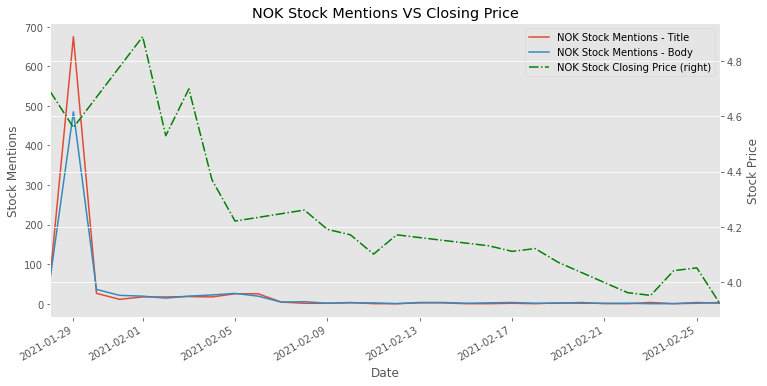

In [61]:
daily_title_df['nok'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'NOK Stock Mentions - Title', legend=True, title= 'NOK Stock Mentions VS Closing Price', ylabel = 'Stock Mentions')
daily_body_df['nok'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'NOK Stock Mentions - Body', legend=True);
nok_data.plot(secondary_y=True, label="NOK Stock Closing Price", legend=True, linestyle='dashdot', color='g')
plt.ylabel('Stock Price')
plt.show();

In [62]:
print('NOK Correlation (Title):',daily_title_df['nok'].corr(nok_data))
print('NOK Correlation (Body):',daily_body_df['nok'].corr(nok_data))

NOK Correlation (Title): 0.3329889553035577
NOK Correlation (Body): 0.3585127158509005


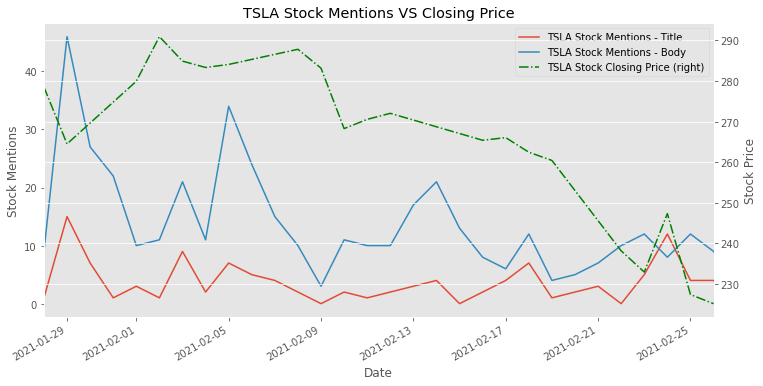

In [63]:
daily_title_df['tsla'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'TSLA Stock Mentions - Title', legend=True, title= 'TSLA Stock Mentions VS Closing Price', ylabel = 'Stock Mentions')
daily_body_df['tsla'].plot(figsize=(12,6),xlim=['2021-01-28','2021-02-26'], label = 'TSLA Stock Mentions - Body', legend=True);
tsla_data.plot(secondary_y=True, label="TSLA Stock Closing Price", legend=True, linestyle='dashdot', color='g')
plt.ylabel('Stock Price')
plt.show();

In [64]:
print('TSLA Correlation (Title):',daily_title_df['tsla'].corr(tsla_data))
print('TSLA Correlation (Body):',daily_body_df['tsla'].corr(tsla_data))

TSLA Correlation (Title): -0.14538108294022573
TSLA Correlation (Body): 0.12372884927483979


# Title Overall Sentiment

In [65]:
sentiment_title = df_title[['timestamp','sentiment_type','Company']]
title_sentiment_df = pd.DataFrame()
def total_sentiment_title(company):
    global title_sentiment_df
    x_sentiment = sentiment_title[sentiment_title['Company'].apply(lambda x: company in x)]
    Date = x_sentiment.timestamp
    sentiments = pd.get_dummies(x_sentiment.sentiment_type.apply(pd.Series).stack()).sum(level=0)
    negative = sentiments.Negative
    neutral = sentiments.Neutral
    positive = sentiments.Positive
    
    x_sentiment_df = pd.get_dummies(x_sentiment.Company.apply(pd.Series).stack()).sum(level=0)
    x_sentiment_df.insert(0, 'Date', Date)
    x_sentiment_df.insert(1, 'Negative', negative)
    x_sentiment_df.insert(2, 'Neutral', neutral)
    x_sentiment_df.insert(3, 'Positive', positive)
    
    x_sentiment_df = x_sentiment_df[['Date','Negative','Neutral','Positive',company]]
    
    x_sentiment_df = x_sentiment_df.groupby('Date').aggregate({'Negative':'sum','Neutral': 'sum', 'Positive': 'sum'})
    x_sentiment_df.index = pd.to_datetime(x_sentiment_df.index)
    
    title_sentiment_df = title_sentiment_df.append(x_sentiment_df.sum().to_frame().T.rename(columns = {company: 'count'}, index={0: company}))

In [66]:
for company in ['gme', 'amc', 'bb', 'nok', 'rh', 'tsla']:
    total_sentiment_title(company)
    
title_sentiment_df = title_sentiment_df[['Positive','Negative','Neutral']]

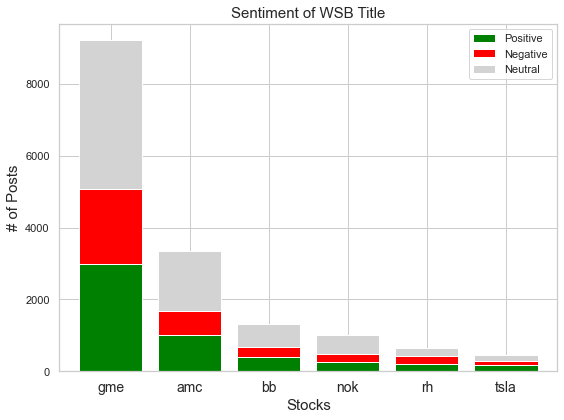

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='whitegrid')

#create stacked bar chart
title_sentiment_df.plot(kind='bar', width=0.8, stacked=True, color=['green', 'red','lightgrey'],figsize=(8,6))
plt.xlabel('Stocks', fontsize=15)
plt.ylabel('# of Posts', fontsize=15)
 
plt.title('Sentiment of WSB Title',fontsize=15)
plt.xticks(rotation = 0, fontsize=14)
plt.xticks(fontsize=14)

plt.tight_layout()
plt.show();

# Body Overall Sentiment

In [68]:
sentiment_body = df_body[['timestamp','sentiment_type','Company']]
body_sentiment_df = pd.DataFrame()
def total_sentiment_body(company):
    global body_sentiment_df
    x_sentiment = sentiment_body[sentiment_body['Company'].apply(lambda x: company in x)]
    Date = x_sentiment.timestamp
    sentiments = pd.get_dummies(x_sentiment.sentiment_type.apply(pd.Series).stack()).sum(level=0)
    negative = sentiments.Negative
    neutral = sentiments.Neutral
    positive = sentiments.Positive
    
    x_sentiment_df = pd.get_dummies(x_sentiment.Company.apply(pd.Series).stack()).sum(level=0)
    x_sentiment_df.insert(0, 'Date', Date)
    x_sentiment_df.insert(1, 'Negative', negative)
    x_sentiment_df.insert(2, 'Neutral', neutral)
    x_sentiment_df.insert(3, 'Positive', positive)
    
    x_sentiment_df = x_sentiment_df[['Date','Negative','Neutral','Positive',company]]
    
    x_sentiment_df = x_sentiment_df.groupby('Date').aggregate({'Negative':'sum','Neutral': 'sum', 'Positive': 'sum'})
    x_sentiment_df.index = pd.to_datetime(x_sentiment_df.index)
    
    body_sentiment_df = body_sentiment_df.append(x_sentiment_df.sum().to_frame().T.rename(columns = {company: 'count'}, index={0: company}))

In [69]:
for company in ['gme', 'amc', 'bb', 'nok', 'rh', 'tsla']:
    total_sentiment_body(company)
    
body_sentiment_df = body_sentiment_df[['Positive','Negative','Neutral']]

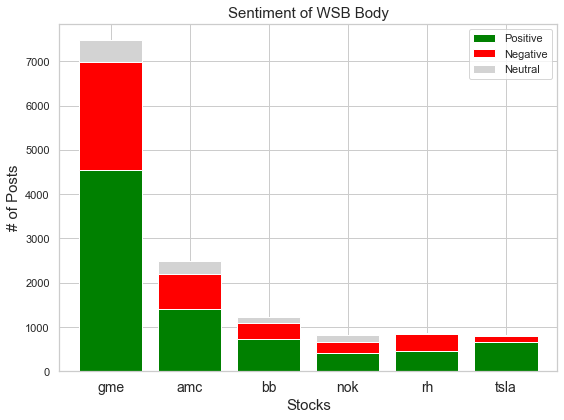

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='whitegrid')

#create stacked bar chart
body_sentiment_df.plot(kind='bar', width=0.8, stacked=True, color=['green', 'red','lightgrey'],figsize=(8,6))
plt.xlabel('Stocks', fontsize=15)
plt.ylabel('# of Posts', fontsize=15)
 
plt.title('Sentiment of WSB Body',fontsize=15)
plt.xticks(rotation = 0, fontsize=14)
plt.xticks(fontsize=14)

plt.tight_layout()
plt.show();